# Classification using dense neural network (fully connected)
For this exercise we'll be using [TensorFlow](https://www.tensorflow.org/). This is a framework specifically tailored
to machine learning. Since we'll be using the [Keras](https://keras.io/) API, you can also have [PyTorch](https://pytorch.org/)
as the underlying framework, if you prefer that. Or, you can also continue with scikit-learn, which also has dense / fully connected networks implemented.

## Normalization of image data
We apply the same normalization as for logistic regression. Recall that we have saved this function in a file
called `helper_functions.py`, and can import and use it directly from there.

## Numpy approach

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.model_selection import train_test_split
from helper_functions import normalize_image_data

In [2]:
# Load images and labels.
DATA_PATH = "../data/"

images = np.load(DATA_PATH+"images_training.npy")
labels = np.load(DATA_PATH+"labels_training.npy")

# Split the training indices into training and validation. 
# Validate with 25% of the data (default). Can be adjusted.
x_idx = np.arange(images.shape[0])
train_idx, val_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.25)

### Build a model
We're going to start off with a simple feed-forward neural network one hidden layer. This is a binary classifier, so
we techincally only need it to output one number.

In [3]:
# Init the Sequential model
model = Sequential()
# Add Input layer
model.add(InputLayer(input_shape=(images.shape[1],)))

# Add hidden layer
model.add(Dense(64, activation='relu'))

# Add output layer.
model.add(Dense(1, activation='sigmoid'))

# Finally, compile the model and print a summary. Loss function and optimizer is set during compilation.
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,513
Trainable params: 16,513
Non-trainable params: 0
_________________________________________________________________


### Train the model
The fit() function returns a history object that we'll store to plot how the training developed with epochs.
First we need to set som training parameters.

Note that if you would like to change something about the the model and run training again, you must
re-compile the model. Otherwise you will essentially just be doubling the number of epochs.

In [4]:
# Set parameters for the training run. For the small set of 10k events you can probably get 
# away with even 100 epochs in a fairly small time, depending on your CPU.
epochs = 20
batch_size = 32

In [5]:
# The validation_data keywork expects a 'tuple' (val_x, val_y) so we make one on the fly
history = model.fit(
    x=normalize_image_data(images[train_idx]),
    y=labels[train_idx],
    validation_data=(normalize_image_data(images[val_idx]), labels[val_idx]),
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/20
211/211 [==============================] - 0s 2ms/step - loss: 0.5576 - accuracy: 0.7209 - val_loss: 0.4938 - val_accuracy: 0.7480
Epoch 2/20
211/211 [==============================] - 0s 1ms/step - loss: 0.4875 - accuracy: 0.7434 - val_loss: 0.4765 - val_accuracy: 0.7573
Epoch 3/20
211/211 [==============================] - 0s 1ms/step - loss: 0.4706 - accuracy: 0.7572 - val_loss: 0.4630 - val_accuracy: 0.7684
Epoch 4/20
211/211 [==============================] - 0s 1ms/step - loss: 0.4561 - accuracy: 0.7665 - val_loss: 0.4525 - val_accuracy: 0.7733
Epoch 5/20
211/211 [==============================] - 0s 1ms/step - loss: 0.4427 - accuracy: 0.7730 - val_loss: 0.4438 - val_accuracy: 0.7809
Epoch 6/20
211/211 [==============================] - 0s 1ms/step - loss: 0.4291 - accuracy: 0.7856 - val_loss: 0.4294 - val_accuracy: 0.7858
Epoch 7/20
211/211 [==============================] - 0s 1ms/step - loss: 0.4141 - accuracy: 0.7975 - val_loss: 0.4154 - val_accuracy: 0.7960
Epoch 

### Evaluate the model
Let's use the history object to plot how the loss and accuracy changed during training.
The history contains a dictionary of the currently applied metrics as keys. In this case we have the
keys "loss", "accuracy", "val_loss", and "val_accuracy". "loss" and "accuracy" pertain to the training data, while
"val_loss" and "val_accuracy" are the metrics for the validation data we provided.

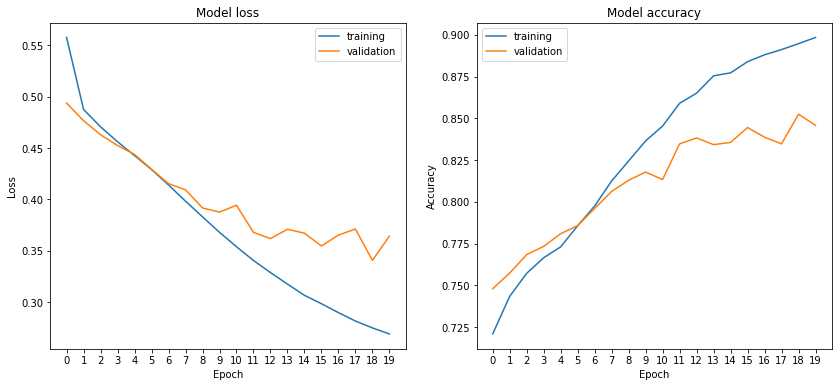

In [15]:
# Plot loss and val_loss as one plot, and accuracy and val_accuracy as another, side-by-side.
# We'll also save this plot as plot_history() in the helper_functions file, so any time we need to
# plot the history object like this we can just call that function and pass the history object as
# an argument.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
num_epochs = len(history.history['loss'])
ax[0].plot(history.history['loss'], label='training')
ax[0].plot(history.history['val_loss'], label='validation')
ax[0].set_title("Model loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_xticks(np.arange(num_epochs))
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='training')
ax[1].plot(history.history['val_accuracy'], label='validation')
ax[1].set_title("Model accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_xticks(np.arange(num_epochs))
ax[1].legend()

The plotting function will only plot these two metrics regardless of how many other metrics we add to the model,
but it's a starting point that can be extended as you might add more metrics.